In [230]:
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

# from experiment file
params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]
# params = [0.0125, 0.0075, 5e-05, 4.99e-05, 0.005, 5e-06, -6.01e-05]
        
original_curve, original_profile = xrd.compute_curve_and_profile(
    array=params,
    dl=400e-8
)

In [231]:
import torch
import xrd
import helpers as h
import model_common
from importlib import reload

# Reload modules to get latest changes
reload(xrd)
reload(model_common)
reload(h)

MODEL_CHECKPOINT = 'checkpoints/dataset_100000_dl400_v2.pt'

device = "mps"

checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"✅ Loaded checkpoint from {MODEL_CHECKPOINT}")
print(f"Checkpoint contains: {list(checkpoint.keys())}")

# Initialize model
model = model_common.XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])

ds = model_common.PickleXRDDataset(
    torch.tensor(original_curve.ML_X, dtype=torch.float32).unsqueeze(0),
    torch.tensor(original_curve.ML_Y, dtype=torch.float32).unsqueeze(0),
    train=False
)
dl = torch.utils.data.DataLoader(ds, batch_size=256)

preds = []
with torch.no_grad():
    for y, _ in dl:
        p = model(y.to(device))
        preds.append(p.to(device))

P = torch.cat(preds, dim=0)
Theta_hat = model_common.denorm_params(P)

✅ Loaded checkpoint from checkpoints/dataset_100000_dl400_v2.pt
Checkpoint contains: ['model', 'L', 'epoch', 'val_loss']


In [232]:
Theta_hat

tensor([[ 1.2365e-02,  3.4660e-03,  5.3217e-05,  4.1442e-05,  9.0292e-03,
          1.7556e-05, -4.2486e-05]], device='mps:0')

Predicted parameters: [ 1.2364521e-02  3.4659901e-03  5.3217336e-05  4.1441548e-05
  9.0291603e-03  1.7555731e-05 -4.2486419e-05]


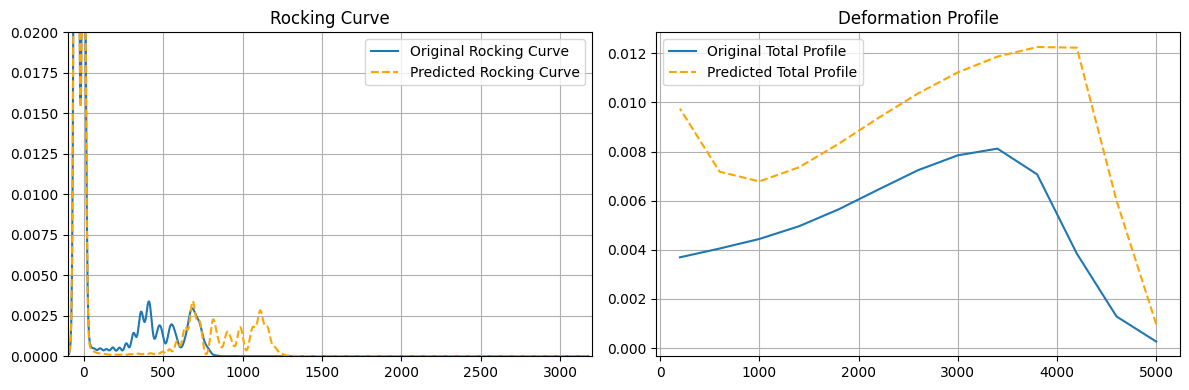

In [233]:
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

predicted_params = Theta_hat[0].cpu().numpy()
print("Predicted parameters:", predicted_params)
        
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=predicted_params,
    dl=400e-8
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 12 width, 4 height

# Rocking Curve: plot original (solid) and predicted (orange, dashed)
axes[0].set_title("Rocking Curve")
axes[0].plot(original_curve.X_DeltaTeta, original_curve.Y_R_vseZ, label="Original Rocking Curve", color='C0', linestyle='-')
axes[0].plot(predicted_curve.X_DeltaTeta, predicted_curve.Y_R_vseZ, label="Predicted Rocking Curve", color='orange', linestyle='--')
axes[0].set_ylim(0, 0.02)
axes[0].set_xlim(-100, 3200)
axes[0].grid(True)
axes[0].legend()

# Deformation Profile: plot original (solid) and predicted (orange, dashed)
axes[1].set_title("Deformation Profile")
axes[1].plot(original_profile.X, original_profile.total_Y, label="Original Total Profile", color='C0', linestyle='-')
axes[1].plot(predicted_profile.X, predicted_profile.total_Y, label="Predicted Total Profile", color='orange', linestyle='--')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
